# **POS Tagging**

# PART 3

## Installs, Imports and Paths

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
!pip install scikit_learn
!pip install nltk
!pip install --upgrade wandb
!pip install datasets
!pip install tensorflow
!pip install scipy
!pip install scikeras
!pip install numpy
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=805b2b142cb6883caad99f9b43cd8835d13570013498cdc3860c111b0f0b2ade
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be00

In [3]:
from google.colab import files
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import pickle
import random
import nltk
import wandb
import os
import string
import spacy
import keras
import urllib.request, zipfile
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, concatenate
from keras.layers import add
from collections import Counter
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.constraints import MaxNorm
from sklearn import preprocessing
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import FastText
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from nltk import sent_tokenize, word_tokenize, pos_tag
from pandas.core.missing import find_valid_index
from sklearn.model_selection import learning_curve, GridSearchCV
from tabulate import tabulate
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
stemmer = WordNetLemmatizer()

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
%env WANDB_LOG_MODEL=true

env: WANDB_LOG_MODEL=true


In [6]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

if not os.path.exists('./POS-Tagging'):
  os.makedirs('./POS-Tagging')
os.chdir('./POS-Tagging')
uploaded = files.upload()

Saving en_lines-ud-dev.txt to en_lines-ud-dev.txt
Saving en_lines-ud-test.txt to en_lines-ud-test.txt
Saving en_lines-ud-train.txt to en_lines-ud-train.txt


## Data Preprocessing

In [7]:
def myData(name, percentage):
  with open(name, "r", encoding="utf-8") as myfile:
    my_data = myfile.read()
    cropped_data = my_data[:int(len(my_data)*percentage)]

  return cropped_data


train_data = myData("en_lines-ud-train.txt", 1) # as a second parameter pass the percentage of the data you want
dev_data = myData("en_lines-ud-dev.txt", 1)
test_data = myData("en_lines-ud-test.txt", 1)

In [8]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('sentencizer')

# tokenize and lemmatize the data and finally create x-y list
def processing(my_data):
  
  tuples=[]
  x = []
  y = []
  for sent in my_data.sents:
    partial_tuple=[]
    temp_x = []
    temp_y = []
    for token in sent:
      if token.pos_:
        temp_x.append(token.lemma_)
        temp_y.append(token.pos_)
        partial_tuple.append((token.lemma_, token.pos_))
    tuples.append(partial_tuple)
    x.append(temp_x)
    y.append(temp_y)
  return tuples, x, y

train_tuples, x_train, y_train = processing(nlp(train_data))
dev_tuples, x_dev, y_dev = processing(nlp(dev_data))
test_tuples, x_test, y_test = processing(nlp(test_data))

## Loading Pre-trained Embeddings

In [9]:
if not os.path.exists('./embeddings'):
  os.makedirs('./embeddings')

urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip', './embeddings/wiki-news-300d-1M.vec.zip')
zip_ref = zipfile.ZipFile('./embeddings/wiki-news-300d-1M.vec.zip', 'r')
zip_ref.extractall('./embeddings')
zip_ref.close()

embs_path = './embeddings/wiki-news-300d-1M.vec'
embeddings = KeyedVectors.load_word2vec_format(embs_path, binary=False)

## Data Manipulation

### Word count

In [10]:
# Initialize the word_index dictionary with an index for the pad token and an index for the oov words
word_index = {'pad': 0, 'oov': 1}

# Flatten the list of tuples into a list of words
all_words = [word for sentence in train_tuples for word, tag in sentence]

# Count the number of occurrences of each word
word_counts = Counter(all_words)

# Create an entry in the word_index dictionary for each unique word, with the index being the current length of the dictionary
for word, count in word_counts.items():
    word_index[word] = len(word_index)

print(word_index)

{'pad': 0, 'oov': 1, 'show': 2, 'all': 3, 'about': 4, 'ANSI': 5, 'SQL': 6, 'query': 7, 'mode': 8, 'some': 9, 'of': 10, 'the': 11, 'content': 12, 'in': 13, 'this': 14, 'topic': 15, 'may': 16, 'not': 17, 'be': 18, '\n': 19, 'applicable': 20, 'to': 21, 'language': 22, '.': 23, 'you': 24, 'can': 25, 'create': 26, 'one': 27, 'two': 28, ':': 29, 'ANSI-89': 30, 'describe': 31, 'traditional': 32, 'Jet': 33, 'syntax': 34, 'conform': 35, 'closely': 36, 'ansi-89': 37, 'Level': 38, '1': 39, 'specification': 40, ',': 41, 'but': 42, 'level': 43, 'compliant': 44, 'certain': 45, 'feature': 46, 'implement': 47, 'and': 48, 'wildcard': 49, 'character': 50, 'visual': 51, 'Basic': 52, 'for': 53, 'Applications': 54, '(': 55, 'VBA': 56, ')': 57, 'ansi-92': 58, 'provide': 59, 'new': 60, 'reserved': 61, 'word': 62, 'rule': 63, 'that': 64, 'enhance': 65, 'your': 66, 'ability': 67, 'filter': 68, 'statement': 69, 'have': 70, 'more': 71, 'Microsoft': 72, 'Access': 73, '2000': 74, 'use': 75, 'adox': 76, 'could': 77

### Create the Embedding Matrix

In [11]:
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = embeddings.vectors.shape[1]


# Get the embedding matrix
vocab_size = len(word_index)  # +1 for OOV, +1 for pad
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
# Add OOV and pad vectors
embedding_matrix[0] = np.random.uniform(-0.25, 0.25, EMBEDDING_DIM)  # OOV vector
embedding_matrix[1] = np.zeros(embeddings.vectors.shape[1])  # pad vector
# Add pre-trained embeddings for known words
for word, i in word_index.items():
  try:
      embedding_matrix[i+2] = embeddings[word]  # +2 to account for OOV and pad vectors
  except:
      pass

### Encode the classes

In [12]:
classes = ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'SYM', 'VERB', 'X']


def mapping(my_list):
    mapping = {}
    for i, string in enumerate(my_list, start=1): # start from 1 so we don't mix classes with pads
        mapping[string] = i
    return mapping

encoded_classes = mapping(classes)

### Cut the sentences and encode

In [13]:
def cut(sentences):
    new=[]
    for data in sentences:
        new.append(([data[x:x+MAX_SEQUENCE_LENGTH] for x in range(0, len(data), MAX_SEQUENCE_LENGTH)]))
    new = [val for sublist in new for val in sublist]
    return new

train_sentences = cut(train_tuples)
dev_sentences = cut(dev_tuples)
test_sentences = cut(test_tuples)

In [14]:
# function that takes tuples (x, y) and returns the corresponding x_train and y_train 
def processing_cnn(tuples):
  
  x = []
  y = []
  for sent in tuples:
    temp_x = []
    for word, index in sent:
      if word in word_index:
        temp_x.append(word_index[word])
      else:
        temp_x.append(word_index['oov']) # oov
    x.append(temp_x)

  for sent in tuples:
    temp_y = []
    for word, index in sent:
      if index in encoded_classes:
        temp_y.append(encoded_classes[index])
      else:
        temp_y.append(encoded_classes['X']) # if its something else then tag it as 'X'

    y.append(temp_y)


  return x, y

  
x_train_rnn, y_train_rnn = processing_cnn(train_sentences)
x_dev_rnn, y_dev_rnn = processing_cnn(dev_sentences) 
x_test_rnn, y_test_rnn = processing_cnn(test_sentences) 

### Generate x_train and 1-hot

In [15]:
x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train_rnn, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
y_train_padded = tf.keras.preprocessing.sequence.pad_sequences(y_train_rnn, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
y_train_cat_padded = to_categorical(y_train_padded, num_classes= len(encoded_classes) + 1)

x_dev_padded = tf.keras.preprocessing.sequence.pad_sequences(x_dev_rnn, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
y_dev_padded = tf.keras.preprocessing.sequence.pad_sequences(y_dev_rnn, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
y_dev_cat_padded = to_categorical(y_dev_padded, num_classes= len(encoded_classes) + 1)

x_test_padded = tf.keras.preprocessing.sequence.pad_sequences(x_test_rnn, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
y_test_padded = tf.keras.preprocessing.sequence.pad_sequences(y_test_rnn, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
y_test_cat_padded = to_categorical(y_test_padded, num_classes= len(encoded_classes) + 1)

## CNN

In [16]:
#Create and train a CNN model with (2,3,4)-gram filters using Keras functional API

with tf.device('/device:GPU:0'):

  inputs = keras.Input((x_train_padded.shape[1],),)
  mask = keras.layers.Masking(mask_value=0)(inputs) # Mask the pads
  embeddings_layer = keras.layers.Embedding(input_dim = vocab_size, output_dim = embeddings.vectors.shape[1],  input_length = MAX_SEQUENCE_LENGTH,
                                            weights = [embedding_matrix], mask_zero = True, trainable = True)(mask)
  # 2grams
  channel_1 = Conv1D(filters = 128, kernel_size=2, padding='same')(embeddings_layer)
  channel_1_2 = Conv1D(filters = 128, kernel_size=2, padding='same')(channel_1)
  channel_1 = add([channel_1, channel_1_2]) # residual connection
  channel_1 = Dropout(0.5)(channel_1) 

  # 3grams
  channel_2 = Conv1D(filters = 128, kernel_size=3, padding='same')(embeddings_layer)
  channel_2_2 = Conv1D(filters= 128, kernel_size=3, padding='same')(channel_2)
  channel_2 = add([channel_2, channel_2_2]) # residual connection
  channel_2 = Dropout(0.5)(channel_2)  

  # 4grams
  channel_3 = Conv1D(filters= 128, kernel_size = 4, padding='same')(embeddings_layer)
  channel_3_2 = Conv1D(filters = 128, kernel_size = 4, padding='same')(channel_3)
  channel_3 = add([channel_3, channel_3_2]) # residual connection
  channel_3 = Dropout(0.5)(channel_3) 
  
  concat = concatenate([channel_1, channel_2, channel_3])

  outputs = Dense(y_train_cat_padded.shape[2], activation='softmax')(concat)  # softmax output layer   
  cnn_model = keras.Model(inputs, outputs)

  print(cnn_model.summary())

  cnn_model.compile(optimizer=Adam(learning_rate = 0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])


  if not os.path.exists('./my_CNN_checkpoint'):
    os.makedirs('./my_CNN_checkpoint')

  cnn_callbacks = [
      keras.callbacks.ModelCheckpoint(
          './my_CNN_checkpoint/weights.hdf5',
          monitor='val_accuracy', 
          mode='max', 
          verbose=2,
          save_best_only=True,
          save_weights_only=True)
  ]

  history = cnn_model.fit(
  x_train_padded,
  y_train_cat_padded,
  batch_size = 128,
  epochs = 20,
  validation_data = (x_dev_padded, y_dev_cat_padded),
  callbacks= cnn_callbacks,
  shuffle = True)


  print(f"Test Accuracy: {cnn_model.evaluate(x_test_padded, y_test_cat_padded)[1]:.5f}")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 masking (Masking)              (None, 300)          0           ['input_1[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     1874700     ['masking[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 300, 128)     76928       ['embedding[0][0]']              
                                                                                              

### Learning Curves

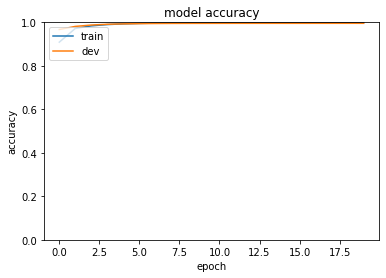

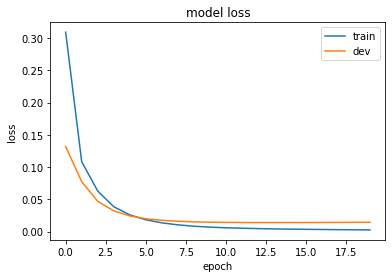

In [17]:
%matplotlib inline

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.ylim(0,1)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

### Helping Functions

In [18]:
def reverse_dict(dictionary):
    reversed_dict = {}
    for key, value in dictionary.items():
        reversed_dict[value] = key
    return reversed_dict

reversed_dictionary = reverse_dict(encoded_classes)

In [19]:
def remove_pads(zipped, mask = 0):
    out_true = []
    out_pred = []
    for zip_i in zipped:
        a, b = tuple(zip_i)
        if a != mask: # Exclude -PAD- term
          out_true.append(reversed_dictionary[a])
          if b not in reversed_dictionary: # The model classified something as 0 which is the pad class
            random.seed(213)
            random_number = random.randint(1, 18)
            b = b + random_number # classify it as something else
            if a==b:
              if a<10: # if randomly we get b=a change b's value because we will get a correct classification but we don't want that
                b = b + 1
              else:
                b = b - 1
          out_pred.append(reversed_dictionary[b])

    return out_true, out_pred

def my_classification_report(x, y, model):

  y_pred = model.predict(x, verbose=1).argmax(-1)
  y_pred_flat = [item for sublist in y_pred for item in sublist] # flatten y_pred
  y_true_flat = [item for sublist in y for item in sublist] # flatten y_true

  tuples = zip(y_true_flat, y_pred_flat)
  y_true, y_pred = remove_pads(tuples, 0)
  return y_true, y_pred

### Model Assessment

In [20]:
with tf.device('/device:GPU:0'):

  inputs = keras.Input((x_train_padded.shape[1],),)
  mask = keras.layers.Masking(mask_value=0)(inputs) # Mask the pads
  embeddings_layer = keras.layers.Embedding(input_dim = vocab_size, output_dim = embeddings.vectors.shape[1],  input_length = MAX_SEQUENCE_LENGTH,
                                            weights = [embedding_matrix], mask_zero = True, trainable = True)(mask)
  # 2grams
  channel_1 = Conv1D(filters = 128, kernel_size=2, padding='same')(embeddings_layer)
  channel_1_2 = Conv1D(filters = 128, kernel_size=2, padding='same')(channel_1)
  channel_1 = add([channel_1, channel_1_2])
  channel_1 = Dropout(0.5)(channel_1) 

  # 3grams
  channel_2 = Conv1D(filters = 128, kernel_size=3, padding='same')(embeddings_layer)
  channel_2_2 = Conv1D(filters= 128, kernel_size=3, padding='same')(channel_2)
  channel_2 = add([channel_2, channel_2_2])
  channel_2 = Dropout(0.5)(channel_2)  

  # 4grams
  channel_3 = Conv1D(filters= 128, kernel_size = 4, padding='same')(embeddings_layer)
  channel_3_2 = Conv1D(filters = 128, kernel_size = 4, padding='same')(channel_3)
  channel_3 = add([channel_3, channel_3_2])
  channel_3 = Dropout(0.5)(channel_3) 
  
  concat = concatenate([channel_1, channel_2, channel_3])

  outputs = Dense(y_train_cat_padded.shape[2], activation='softmax')(concat)  # softmax output layer   
  cnn_model = keras.Model(inputs, outputs)
  
  # Load weights from the pre-trained model
  cnn_model.load_weights("./my_CNN_checkpoint/weights.hdf5")
  cnn_model.compile(
      loss='categorical_crossentropy',
      optimizer= Adam(learning_rate=0.001),
      metrics=["accuracy"]
      )

y_train_true, y_train_pred_CNN = my_classification_report(x_train_padded, y_train_padded, cnn_model)
m_train_f1_score = f1_score(y_train_true, y_train_pred_CNN, average = 'macro')
print("Train f1-score: {:.2f}% \n".format(m_train_f1_score*100))

y_dev_true, y_dev_pred_CNN = my_classification_report(x_dev_padded, y_dev_padded, cnn_model)
m_dev_f1_score = f1_score(y_dev_true, y_dev_pred_CNN, average = 'macro')
print("Evaluation f1-score: {:.2f}% \n".format(m_dev_f1_score*100))

y_test_true, y_test_pred_CNN = my_classification_report(x_test_padded, y_test_padded, cnn_model)
m_test_f1_score = f1_score(y_test_true, y_test_pred_CNN, average = 'macro')
print("Test f1-score: {:.2f}% \n".format(m_test_f1_score*100))

97/97 [==============================] - 21s 215ms/step
Train f1-score: 91.42% 

33/33 [==============================] - 8s 241ms/step
Evaluation f1-score: 79.76% 

32/32 [==============================] - 6s 201ms/step
Test f1-score: 80.07% 



### Precision, Recall, AUC, ROC-AUC

In [21]:
# BE CAREFUL! This function is used only for the next chunk of code. It is used to scale the dictionary from (1-18) to (0-17) in order to avoid index error. Do not use for any other code chunk!
def encode_1d_list(list_1d, encoding_dict):
    encoded_list_1d = []
    for item in list_1d:
        encoded_list_1d.append(encoding_dict[item])
    for i in range(len(encoded_list_1d)):
        encoded_list_1d[i] -= 1
    return encoded_list_1d

In [22]:
def errorCheck(y_true, y_pred):

  # Find the unique classes in y_true and y_pred
  unique_classes = np.unique(np.concatenate((y_true, y_pred)))

  # Find the classes present in y_true but not in y_pred
  missing_classes_y_pred = unique_classes[np.in1d(unique_classes, y_true) & ~np.in1d(unique_classes, y_pred)]

  # Find the classes present in y_pred but not in y_true
  missing_classes_y_true = unique_classes[np.in1d(unique_classes, y_pred) & ~np.in1d(unique_classes, y_true)]

  # Calculate the sample size before modifying y_pred and y_true and my_max to know which has the extra class
  if len(y_pred) > len(y_true):
    my_max = y_pred
  else:
    my_max = y_true

  sample_size = max(len(y_pred), len(y_true))

  # Modify y_pred to include all the classes present in y_true
  for c in missing_classes_y_pred:
      y_pred = np.append(y_pred, c)

  # Modify y_true to include all the classes present in y_pred
  for c in missing_classes_y_true:
      y_true = np.append(y_true, c)
  
  y_pred_onehot = np.eye(len(unique_classes))[y_pred[:sample_size]]
  y_true_onehot = np.eye(len(unique_classes))[y_true[:sample_size]]

  return y_true, y_true_onehot, y_pred, y_pred_onehot, my_max

In [23]:
def calculate_CNN_Results(x, y_true, y_pred):

  y_pred_enc = encode_1d_list(y_pred, encoded_classes)
  y_true_enc = encode_1d_list(y_true, encoded_classes)

  train_precision_score = precision_score(y_true_enc, y_pred_enc, average = None)
  train_recall_score = recall_score(y_true_enc, y_pred_enc, average = None)
  train_f1_score = f1_score(y_true_enc, y_pred_enc, average = None)


  m_train_precision_score = precision_score(y_true_enc, y_pred_enc, average = 'macro')
  m_train_recall_score = recall_score(y_true_enc, y_pred_enc, average = 'macro')
  m_train_f1_score = f1_score(y_true_enc, y_pred_enc, average = 'macro')

  # Error checking

  unique_pred = np.unique(y_pred_enc)
  unique_true = np.unique(y_true_enc)

  if unique_pred.shape != unique_true.shape:
      y_true_upd, y_true_onehot, y_pred_upd, y_pred_onehot, my_max = errorCheck(y_true_enc, y_pred_enc)

  elif unique_pred.shape == unique_true.shape and (unique_pred != unique_true).any():
      y_true_upd, y_true_onehot, y_pred_upd, y_pred_onehot, my_max = errorCheck(y_true_enc, y_pred_enc)

  else:
    my_max = y_pred_enc # y_pred or y_true is the same thing in this case
    # One-hot encode the predicted class labels
    y_pred_onehot = np.eye(len(np.unique(y_pred_enc)))[y_pred_enc]

    # One-hot encode the true class labels
    y_true_onehot = np.eye(len(np.unique(y_true_enc)))[y_true_enc]


  m_train_roc_auc_score = roc_auc_score(y_true_onehot, y_pred_onehot, multi_class= 'ovr', average = 'macro')

  # auc calculation is a bit more messy

  classes = np.unique(my_max) # get the classes of the model
  train_roc_auc_score = {}
  for i in range(len(classes)):
      c = classes[i]
      # Prepares an auxiliar dataframe to help with the plots
      df_x = pd.DataFrame (x) # convert list to a dataframe
      y_proba = y_pred_onehot # calculate the probabilities
      df_aux = df_x.copy()
      df_aux_flat = df_aux.values.flatten()

      list_aux_flat = []
      # Delete the paddings from the dataframe and "normalize" the value to be in the scale 0 - 17
      for j in df_aux_flat:
        if j!=0:
          list_aux_flat.append(j)
      df_aux_upd = pd.DataFrame (list_aux_flat)

      df_aux_upd['class'] = [1 if y == c else 0 for y in y_true_enc]
      df_aux_upd['prob'] = y_proba[:, i]
      df_aux_upd = df_aux_upd.reset_index(drop = True)
    
      # Calculates the ROC AUC OvR
      train_roc_auc_score[c] = roc_auc_score(df_aux_upd['class'], df_aux_upd['prob'])

  table = [['    ', 'Precision', 'Recall', 'F1', 'AUC', 'Macro-Precision', 'Macro-Recall', 'Macro-F1', 'Macro-AUC'], 
           ['ADJ', round(train_precision_score[0], 3), round(train_recall_score[0], 3), round(train_f1_score[0], 3), round(train_roc_auc_score[0], 3), '-', '-', '-', '-'],
           ['ADP', round(train_precision_score[1], 3), round(train_recall_score[1], 3), round(train_f1_score[1], 3), round(train_roc_auc_score[1], 3), '-', '-', '-', '-'],
           ['ADV', round(train_precision_score[2], 3), round(train_recall_score[2], 3), round(train_f1_score[2], 3), round(train_roc_auc_score[2], 3), '-', '-', '-', '-'],
           ['AUX', round(train_precision_score[3], 3), round(train_recall_score[3], 3), round(train_f1_score[3], 3), round(train_roc_auc_score[3], 3), '-', '-', '-', '-'],
           ['CCONJ', round(train_precision_score[4], 3), round(train_recall_score[4], 3), round(train_f1_score[4], 3), round(train_roc_auc_score[4], 3), '-', '-', '-', '-'],
           ['DET', round(train_precision_score[5], 3), round(train_recall_score[5], 3), round(train_f1_score[5], 3), round(train_roc_auc_score[5], 3), '-', '-', '-', '-'],
           ['INTJ', round(train_precision_score[6], 3), round(train_recall_score[6], 3), round(train_f1_score[6], 3), round(train_roc_auc_score[6], 3), '-', '-', '-', '-'],
           ['NOUN', round(train_precision_score[7], 3), round(train_recall_score[7], 3), round(train_f1_score[7], 3), round(train_roc_auc_score[7], 3), '-', '-', '-', '-'],
           ['NUM', round(train_precision_score[8], 3), round(train_recall_score[8], 3), round(train_f1_score[8], 3), round(train_roc_auc_score[8], 3), '-', '-', '-', '-'],
           ['PART', round(train_precision_score[9], 3), round(train_recall_score[9], 3), round(train_f1_score[9], 3), round(train_roc_auc_score[9], 3), '-', '-', '-', '-'],
           ['PRON', round(train_precision_score[10], 3), round(train_recall_score[10], 3), round(train_f1_score[10], 3), round(train_roc_auc_score[10], 3), '-', '-', '-', '-'],
           ['PROPN', round(train_precision_score[11], 3), round(train_recall_score[11], 3), round(train_f1_score[11], 3), round(train_roc_auc_score[11], 3), '-', '-', '-', '-'],
           ['PUNCT', round(train_precision_score[12], 3), round(train_recall_score[12], 3), round(train_f1_score[12], 3), round(train_roc_auc_score[12], 3), '-', '-', '-', '-'],
           ['SCONJ', round(train_precision_score[13], 3), round(train_recall_score[13], 3), round(train_f1_score[13], 3), round(train_roc_auc_score[13], 3), '-', '-', '-', '-'],
           ['SPACE', round(train_precision_score[14], 3), round(train_recall_score[14], 3), round(train_f1_score[14], 3), round(train_roc_auc_score[14], 3), '-', '-', '-', '-'],
           ['SYM', round(train_precision_score[15], 3), round(train_recall_score[15], 3), round(train_f1_score[15], 3), round(train_roc_auc_score[15], 3), '-', '-', '-', '-'],
           ['VERB', round(train_precision_score[16], 3), round(train_recall_score[16], 3), round(train_f1_score[16], 3), round(train_roc_auc_score[16], 3), '-', '-', '-', '-'],
           ['X', round(train_precision_score[17], 3), round(train_recall_score[17], 3), round(train_f1_score[17], 3), round(train_roc_auc_score[17], 3), '-', '-', '-', '-'],
           ['Total', '-', '-','-','-', round(m_train_precision_score, 3), round(m_train_recall_score, 3), round(m_train_f1_score, 3), round(m_train_roc_auc_score, 3)]]

  print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
  return table

In [24]:
print("CNN ---------------------------------------------------------------------------------------------------------\n")

print("The training results: \n")
cnn_train_table = calculate_CNN_Results(x_train_padded, y_train_true, y_train_pred_CNN)

print("The evaluation results: \n")
cnn_dev_table = calculate_CNN_Results(x_dev_padded, y_dev_true, y_dev_pred_CNN)

print("The test results: \n")
cnn_test_table = calculate_CNN_Results(x_test_padded, y_test_true, y_test_pred_CNN)

CNN ---------------------------------------------------------------------------------------------------------

The training results: 



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


╒════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│        │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │ Macro-AUC   │
╞════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ ADJ    │ 0.987       │ 0.983    │ 0.985 │ 0.991 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADP    │ 0.989       │ 0.993    │ 0.991 │ 0.996 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADV    │ 0.975       │ 0.968    │ 0.972 │ 0.984 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼─

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


╒════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│        │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │ Macro-AUC   │
╞════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ ADJ    │ 0.888       │ 0.798    │ 0.841 │ 0.896 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADP    │ 0.956       │ 0.973    │ 0.965 │ 0.984 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADV    │ 0.914       │ 0.813    │ 0.861 │ 0.905 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼─

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


╒════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│        │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │ Macro-AUC   │
╞════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ ADJ    │ 0.859       │ 0.79     │ 0.823 │ 0.891 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADP    │ 0.956       │ 0.971    │ 0.963 │ 0.983 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADV    │ 0.907       │ 0.81     │ 0.856 │ 0.903 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼─

### Hyper Parameter Tuning

In [25]:
with tf.device('/device:GPU:0'):
  
  def nn_model(optimizer = 'Adam', dropout = 0.5, trainable = True, filters = 128, learning_rate = 0.01):
    inputs = keras.Input((x_train_padded.shape[1],),)
    mask = keras.layers.Masking(mask_value=0)(inputs) # Mask the pads
    embeddings_layer = keras.layers.Embedding(input_dim = vocab_size, output_dim = embeddings.vectors.shape[1],  input_length = MAX_SEQUENCE_LENGTH,
                                            weights = [embedding_matrix], mask_zero = True, trainable = trainable)(mask)
    # 2grams
    channel_1 = Conv1D(filters = filters, kernel_size=2, padding='same')(embeddings_layer)
    channel_1_2 = Conv1D(filters = filters, kernel_size=2, padding='same')(channel_1)
    channel_1 = add([channel_1, channel_1_2]) # residual connection
    channel_1 = Dropout(dropout)(channel_1) 

    # 3grams
    channel_2 = Conv1D(filters = filters, kernel_size=3, padding='same')(embeddings_layer)
    channel_2_2 = Conv1D(filters= filters, kernel_size=3, padding='same')(channel_2)
    channel_2 = add([channel_2, channel_2_2]) # residual connection
    channel_2 = Dropout(dropout)(channel_2)  

    # 4grams
    channel_3 = Conv1D(filters= filters, kernel_size = 4, padding='same')(embeddings_layer)
    channel_3_2 = Conv1D(filters = filters, kernel_size = 4, padding='same')(channel_3)
    channel_3 = add([channel_3, channel_3_2]) # residual connection
    channel_3 = Dropout(dropout)(channel_3) 
  
    concat = concatenate([channel_1, channel_2, channel_3])
    flatten = keras.layers.Flatten()(concat)
    outputs = Dense(y_train_cat_padded.shape[2], activation='softmax')(flatten)  # softmax output layer   
    cnn_model = keras.Model(inputs, outputs)

    print(cnn_model.summary())
    cnn_model.compile(optimizer = tune_lr(optimizer, learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return cnn_model

  def tune_lr(optimizer, learning_rate):
    optimizerDict = {'Adam': Adam(learning_rate=learning_rate), 'SGD': SGD(learning_rate=learning_rate), 'RMSprop': RMSprop(learning_rate=learning_rate)}
    result = optimizerDict[optimizer]
    
    return result

  filters = [64, 128, 256]
  learning_rate = [0.001, 0.01, 0.1]
  optimizer = ['SGD', 'Adam']
  trainable = [True, False]
  dropout = [0.2, 0.4, 0.5]
  param_grid = dict(optimizer = optimizer, dropout = dropout, trainable = trainable, filters = filters, learning_rate = learning_rate)
  clf = KerasClassifier(build_fn = nn_model, epochs = 5, verbose = 2, optimizer = optimizer, dropout = dropout, trainable = trainable,
                        filters = filters, learning_rate = learning_rate)
  cnn_model = RandomizedSearchCV(estimator= clf, cv = 5, param_distributions = param_grid, n_jobs=-1,verbose = 2,random_state=1234)
  nsamples, nx, ny = y_dev_cat_padded.shape
  y_dev_cat_padded_2d = y_dev_cat_padded[:, 0, :]  # 1045, 300, 19 --> 1045, 19
  cnn_model.fit(x_dev_padded, y_dev_cat_padded_2d)

print("Best estimator \n", cnn_model.best_estimator_)
print("Best score \n", cnn_model.best_score_)
print("Best params \n", cnn_model.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 masking_2 (Masking)            (None, 300)          0           ['input_3[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 300, 300)     1874700     ['masking_2[0][0]']              
                                                                                                  
 conv1d_12 (Conv1D)             (None, 300, 64)      38464       ['embedding_2[0][0]']            
                                                                                            